In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.98.219.98:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.98.219.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.219.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
import json
import numpy as np
import os
import functools,operator
import random
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, Bidirectional)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model, load_model

from tensorflow.keras.layers import add
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from random import shuffle
from collections import OrderedDict 
from keras.layers import Lambda
from keras import backend as K
from keras.regularizers import l2

In [4]:
with open("/content/drive/MyDrive/CS5242/datafile/training_annotation.json") as file:
    training_annotation = json.load(file)

with open("/content/drive/MyDrive/CS5242/datafile/object1_object2.json") as file:
    object1_object2 = json.load(file)
    
with open("/content/drive/MyDrive/CS5242/datafile/relationship.json") as file:
    relationship = json.load(file)

In [5]:
def get_relationship(val):
    for key, value in relationship.items():
        if val == value:
            return key
    return "relationship key doesn't exist"

def get_object(val):
    for key, value in object1_object2.items():
        if val == value:
            return key
    return "object key doesn't exist"

In [6]:
def save_descriptions(training_annotation, filename):
  lines = list()
  for key in training_annotation.keys():
    item = training_annotation[key]
    object1 = get_object(item[0])
    relationship = get_relationship(item[1])
    object2 = get_object(item[2])
    lines.append(key + ' ' + object1 + ' ' + relationship + ' ' + object2)

  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

In [7]:
filename = '/content/drive/MyDrive/CS5242/datafile/train/descriptions.txt'
save_descriptions(training_annotation, filename)

In [8]:
file = open(filename, 'r')
text = file.read()

# process line by line
descriptions = {}
for line in text.split('\n'):
  tokens = line.split()
  image_id, image_desc = tokens[0], tokens[1:]
  desc = '<BOS> ' + ' '.join(image_desc) + ' <EOS>'
  descriptions[image_id] = desc

In [9]:
# tokenize description

output_length = 5

vectorizer = TextVectorization(standardize = None, output_sequence_length=output_length)
text_ds = tf.data.Dataset.from_tensor_slices([descriptions[i] for i in descriptions])
vectorizer.adapt(text_ds)
for i in descriptions:
  descriptions[i] = vectorizer([[descriptions[i]]])

In [10]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
index_word = dict(zip(range(len(voc)), voc))

In [11]:
np.random.seed(5242)

# Train test split
train_split = 0.85

descriptions_random = descriptions.copy()
descriptions_random = list(descriptions.items())
random.shuffle(descriptions_random)
training_list = descriptions_random[:int(len(descriptions) * train_split)]
validation_list = descriptions_random[int(len(descriptions) * train_split):]

training_dict = dict(training_list)
validation_dict = dict(validation_list)

In [ ]:
#for full training and no val
np.random.seed(5242)

# Train test split
train_split = 1

descriptions_random = descriptions.copy()
descriptions_random = list(descriptions.items())
random.shuffle(descriptions_random)
training_list_all = descriptions_random[:int(len(descriptions) * train_split)]
# validation_list = descriptions_random[int(len(descriptions) * train_split):]

training_dict_all = dict(training_list_all)
# validation_dict = dict(validation_list)

In [12]:
def load_dataset(video_features_path, num_decoder_tokens, training_dict, output_length):
  encoder_input_data = []
  decoder_input_data = []
  decoder_target_data = []

  for idx in training_dict:
    video_features = np.load(video_features_path + idx + '.npy')
    encoder_input_data.append(video_features)
    y = to_categorical(training_dict[idx][0], num_decoder_tokens)
    decoder_input_data.append(y)
    decoder_target_data.append(y)

    encoder_input = np.array(encoder_input_data)
    decoder_input = np.array(decoder_input_data)
    decoder_target = np.array(decoder_target_data)

  return [encoder_input, decoder_input], decoder_target

In [13]:
# declare variables

"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
"""

#which hyper-params can be latent-dim, optimizer, learning_rate

epochs = 1000
batch_size = 32
time_steps_encoder = 30
num_encoder_tokens = 2048
latent_dim = 512
time_steps_decoder = output_length
num_decoder_tokens = len(voc)

video_features_path = '/content/drive/MyDrive/CS5242/datafile/train/features/'


In [14]:
X_train, y_train = load_dataset(video_features_path=video_features_path, num_decoder_tokens=num_decoder_tokens, training_dict=training_dict, output_length=output_length)
X_val, y_val = load_dataset(video_features_path=video_features_path, num_decoder_tokens=num_decoder_tokens, training_dict=validation_dict, output_length=output_length)

In [ ]:
X_train_all, y_train_all = load_dataset(video_features_path=video_features_path, num_decoder_tokens=num_decoder_tokens, training_dict=training_dict_all, output_length=output_length)

In [ ]:
print("encoder_input shape:", X_train[0].shape)
print("decoder_input shape:", X_train[1].shape)
print("decoder_target shape:", y_train.shape)

encoder_input shape: (379, 30, 2048)
decoder_input shape: (379, 5, 121)
decoder_target shape: (379, 5, 121)


In [ ]:
print("encoder_input shape:", X_train_all[0].shape)
print("decoder_input shape:", X_train_all[1].shape)
print("decoder_target shape:", y_train_all.shape)

encoder_input shape: (447, 30, 2048)
decoder_input shape: (447, 5, 121)
decoder_target shape: (447, 5, 121)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 30, 2048)]   0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 5, 121)]     0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 30, 512), (N 5244928     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, 5, 512), (No 1298432     decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]           

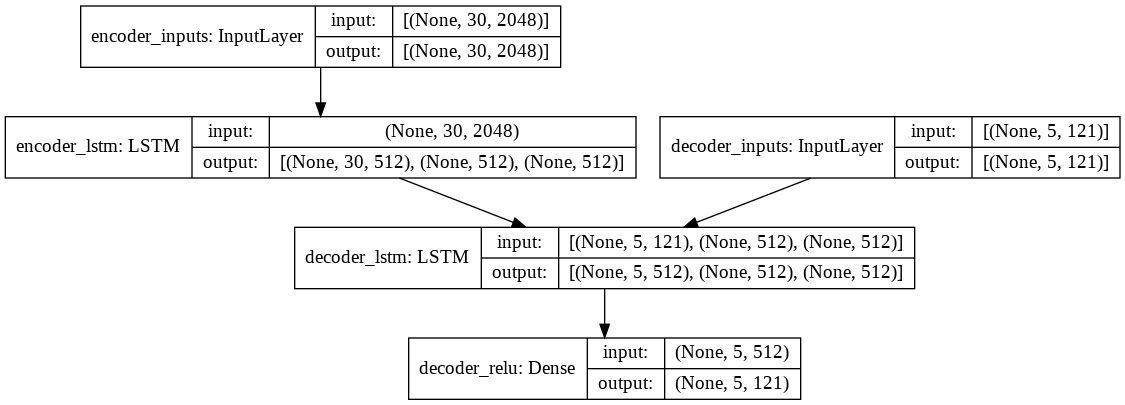

In [15]:
# set up encoder trial 
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name='encoder_inputs')
encoder = LSTM(latent_dim, kernel_regularizer = l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_state=True, return_sequences=True, name='encoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# set up decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name = 'decoder_inputs')
decoder_lstm = LSTM(latent_dim, kernel_regularizer = l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
# decoder_outputs = Dropout(0.25)(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)

# model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

In [16]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Run training
opt = tf.keras.optimizers.Adam(lr=0.001)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='kullback_leibler_divergence')

try:
  model.fit(x = X_train, y = y_train, batch_size = batch_size, validation_data = (X_val, y_val), validation_steps=(len(validation_dict)//batch_size), epochs=epochs, callbacks=[x, earlystopping])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

Epoch 1/1000
12/12 [==============================] - 7s 261ms/step - loss: 42.2099 - accuracy: 0.2589 - val_loss: 28.3878 - val_accuracy: 0.4000
Epoch 2/1000
12/12 [==============================] - 2s 142ms/step - loss: 25.3834 - accuracy: 0.4131 - val_loss: 18.3939 - val_accuracy: 0.5031
Epoch 3/1000
12/12 [==============================] - 2s 141ms/step - loss: 17.0022 - accuracy: 0.5596 - val_loss: 14.3409 - val_accuracy: 0.5562
Epoch 4/1000
12/12 [==============================] - 2s 142ms/step - loss: 13.5832 - accuracy: 0.6368 - val_loss: 12.7889 - val_accuracy: 0.5875
Epoch 5/1000
12/12 [==============================] - 2s 142ms/step - loss: 12.0699 - accuracy: 0.6974 - val_loss: 11.9741 - val_accuracy: 0.6000
Epoch 6/1000
12/12 [==============================] - 2s 142ms/step - loss: 11.2393 - accuracy: 0.7310 - val_loss: 11.5673 - val_accuracy: 0.6062
Epoch 7/1000
12/12 [==============================] - 2s 142ms/step - loss: 10.7563 - accuracy: 0.7477 - val_loss: 11.3329 -

In [ ]:
#training on entire data
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Run training
opt = tf.keras.optimizers.Adamax(lr=0.001)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')

try:
  model.fit(x = X_train_all, y = y_train_all, batch_size = batch_size, epochs=130)
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

Epoch 1/130
14/14 [==============================] - 12s 565ms/step - loss: 9.9919 - accuracy: 0.6073
Epoch 2/130
14/14 [==============================] - 8s 560ms/step - loss: 7.3382 - accuracy: 0.8444
Epoch 3/130
14/14 [==============================] - 8s 560ms/step - loss: 6.4696 - accuracy: 0.8948
Epoch 4/130
14/14 [==============================] - 8s 560ms/step - loss: 5.8860 - accuracy: 0.9291
Epoch 5/130
14/14 [==============================] - 8s 561ms/step - loss: 5.4280 - accuracy: 0.9346
Epoch 6/130
14/14 [==============================] - 8s 560ms/step - loss: 5.1183 - accuracy: 0.9325
Epoch 7/130
14/14 [==============================] - 8s 559ms/step - loss: 4.7476 - accuracy: 0.9467
Epoch 8/130
14/14 [==============================] - 8s 561ms/step - loss: 4.4404 - accuracy: 0.9495
Epoch 9/130
14/14 [==============================] - 8s 558ms/step - loss: 4.1564 - accuracy: 0.9541
Epoch 10/130
14/14 [==============================] - 8s 558ms/step - loss: 3.9106 - accur

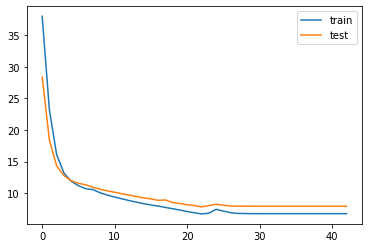

In [18]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss.png')
plt.show()

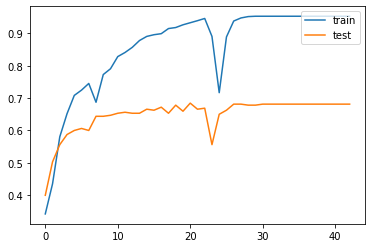

In [19]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy.png')
plt.show()

In [20]:
save_model_path = '/content/drive/MyDrive/CS5242/datafile/train/sid_models'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

encoder_model_name = 'encoder_model_best_submit.h5'
decoder_model_name = 'decoder_model_best_submit.h5'

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

encoder_model.save(os.path.join(save_model_path, encoder_model_name))
decoder_model.save_weights(os.path.join(save_model_path, decoder_model_name))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 30, 2048)]        0         
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 30, 512), (None,  5244928   
Total params: 5,244,928
Trainable params: 5,244,928
Non-trainable params: 0
_________________________________________________________________


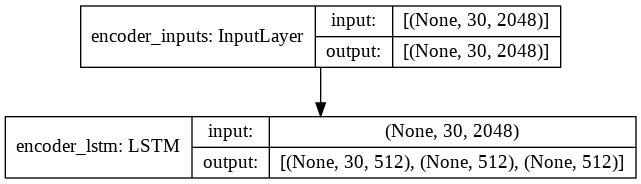

In [21]:
encoder_model.summary()
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, 5, 121)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, 5, 512), (No 1298432     decoder_inputs[0][0]             
                                                                 input_1[0][0]              

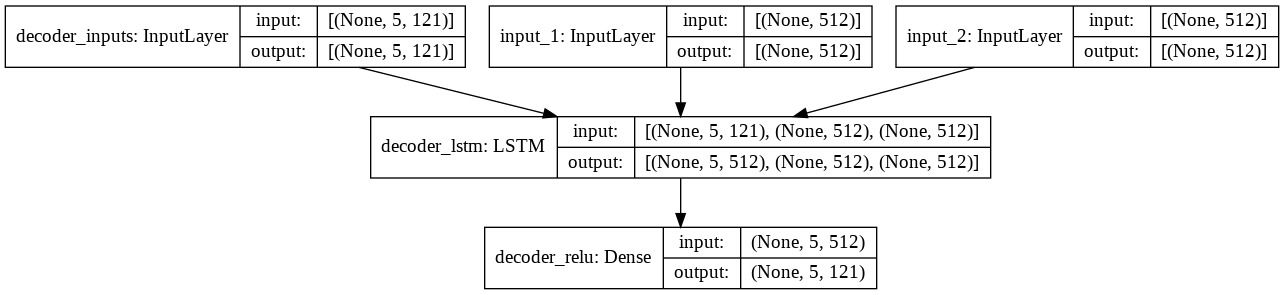

In [22]:
decoder_model.summary()
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

### Inference

In [ ]:
# declare variables

"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
"""
epochs = 1000
batch_size = 32
time_steps_encoder = 30
num_encoder_tokens = 2048
latent_dim = 1024
time_steps_decoder = output_length
num_decoder_tokens = len(voc)
save_model_path = '/content/drive/MyDrive/CS5242/datafile/train/sid_models'
encoder_model_name = 'encoder_model_method4_full.h5'
decoder_model_name = 'decoder_model_weights_method4_full.h5'

In [23]:
# inference encoder model
inf_encoder_model = load_model(os.path.join(save_model_path, encoder_model_name))

# inference decoder model
decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

inf_decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
inf_decoder_model.load_weights(os.path.join(save_model_path, decoder_model_name))

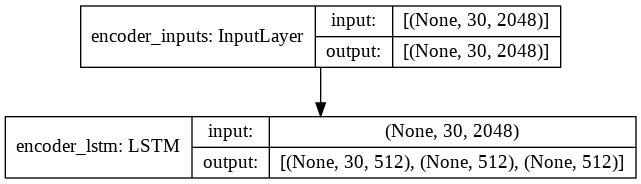

In [24]:
plot_model(inf_encoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

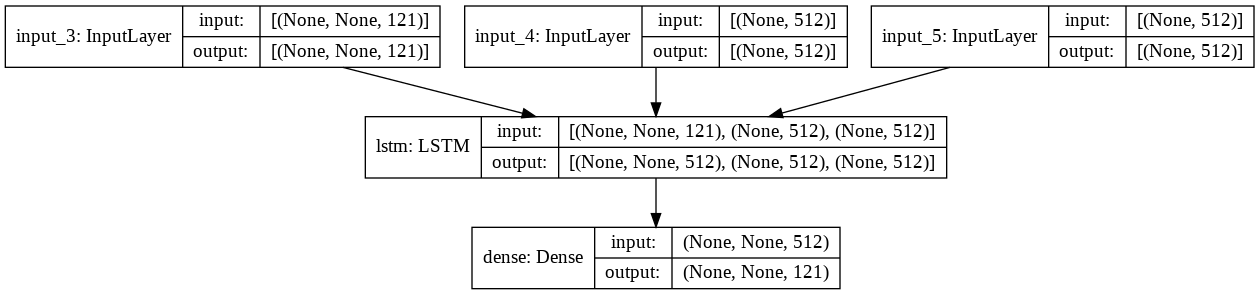

In [25]:
plot_model(inf_decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

## Exhaustive Search

In [ ]:
def exhaustive_search(video_features):
  node = 50
  all_candidates = []

  # initialise prediction with <BOS>
  states_value = inf_encoder_model.predict(video_features)
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, word_index['<BOS>']] = 1
  output_tokens, h, c = inf_decoder_model.predict([target_seq] + states_value)
  output_tokens = output_tokens.reshape((num_decoder_tokens))
  sampled_token_index = output_tokens.argsort()[-node:][::-1]
  states_value = [h, c]

  # predict for every node
  for i in sampled_token_index:
    if (index_word[i] == '<BOS>') or (index_word[i] == '<EOS>') or (index_word[i] not in object1_object2.keys()):
      continue
    
    else:
      path = []
      score = 0.0

      sampled_char = index_word[i]
      prob = output_tokens[i]
      score = score - np.log(prob)
      path.append(sampled_char)

      target_seq_2 = np.zeros((1, 1, num_decoder_tokens))
      target_seq_2[0, 0, i] = 1
      output_tokens_2, h_2, c_2 = inf_decoder_model.predict([target_seq_2] + states_value)
      output_tokens_2 = output_tokens_2.reshape((num_decoder_tokens))
      sampled_token_index_2 = output_tokens_2.argsort()[-node:][::-1]
      states_value_2 = [h_2, c_2]

      for i in sampled_token_index_2:
        if (index_word[i] == '<BOS>') or (index_word[i] == '<EOS>') or (index_word[i] not in relationship.keys()):
          continue
        
        else:
          path_2 = path.copy()
          score_2 = score.copy()

          sampled_char_2 = index_word[i]
          prob_2 = output_tokens_2[i]
          score_2 = score - np.log(prob_2)
          path_2.append(sampled_char_2)

          target_seq_3 = np.zeros((1, 1, num_decoder_tokens))
          target_seq_3[0, 0, i] = 1
          output_tokens_3, h_3, c_3 = inf_decoder_model.predict([target_seq_3] + states_value_2)
          output_tokens_3 = output_tokens_3.reshape((num_decoder_tokens))
          sampled_token_index_3 = output_tokens_3.argsort()[-node:][::-1]
          states_value_3 = [h_3, c_3]

          for i in sampled_token_index_3:
            if (index_word[i] == '<BOS>') or (index_word[i] == '<EOS>') or (index_word[i] not in object1_object2.keys()):
              continue
            
            else:
              path_3 = path_2.copy()
              score_3 = score_2.copy()

              sampled_char_3 = index_word[i]
              prob_3 = output_tokens_3[i]
              score_3 = score_2 - np.log(prob_3)
              path_3.append(sampled_char_3)
              
              candidate = [path_3, score_3]
              all_candidates.append(candidate)

  ordered = sorted(all_candidates, key=lambda tup:tup[1])
  return ordered

In [ ]:
def get_top5_preds(ordered):

  top = 5

  preds = [lst[0] for lst in ordered]
  obj1 = [lst[0] for lst in preds]
  rel = [lst[1] for lst in preds]
  obj2 = [lst[2] for lst in preds]

  obj1_top5 = []
  rel_top5 = []
  obj2_top5 = []

  for i in obj1:
    if i not in obj1_top5:
      obj1_top5.append(i)
    if len(obj1_top5) == top:
      break

  for i in rel:
    if i not in rel_top5:
      rel_top5.append(i)
    if len(rel_top5) == top:
      break

  for i in obj2:
    if i not in obj2_top5:
      obj2_top5.append(i)
    if len(obj2_top5) == top:
      break

  dic_words = {'object1': ' '.join(obj1_top5), 'relationship':' '.join(rel_top5), 'object2:':' '.join(obj2_top5)}

  obj1_top5_idx = [str(object1_object2[word]) for word in obj1_top5]
  rel_top5_idx = [str(relationship[word]) for word in rel_top5]
  obj2_top5_idx = [str(object1_object2[word]) for word in obj2_top5]

  dic_idx = {'object1': ' '.join(obj1_top5_idx), 'relationship':' '.join(rel_top5_idx), 'object2':' '.join(obj2_top5_idx)}
  
  # for validation set format for comparison
  val_format = []
  val_format.append(object1_object2[obj1_top5[0]])
  val_format.append(relationship[rel_top5[0]])
  val_format.append(object1_object2[obj2_top5[0]])

  return dic_words, dic_idx, val_format

In [ ]:
validation_dict.keys()

dict_keys(['000409', '000342', '000430', '000112', '000245', '000408', '000143', '000220', '000018', '000244', '000021', '000243', '000276', '000118', '000070', '000074', '000423', '000100', '000048', '000231', '000285', '000345', '000396', '000177', '000442', '000109', '000286', '000407', '000103', '000328', '000129', '000299', '000416', '000097', '000020', '000262', '000031', '000128', '000157', '000218', '000333', '000140', '000363', '000017', '000192', '000238', '000173', '000210', '000370', '000113', '000145', '000291', '000156', '000180', '000316', '000446', '000204', '000305', '000167', '000385', '000027', '000195', '000029', '000095', '000297', '000170', '000277', '000043'])

In [ ]:
video = '000245'
video_features = np.load('/content/drive/MyDrive/CS5242/datafile/train/features/' + video + '.npy')
video_features = video_features.reshape(-1, video_features.shape[0], video_features.shape[1])
ordered = exhaustive_search(video_features)
dic_words, dic_idx, val_format = get_top5_preds(ordered)
dic_words

{'object1': 'car whale bear antelope fox',
 'object2:': 'car person squirrel',
 'relationship': 'move_behind'}

In [ ]:
ordered

[[['person', 'larger', 'car'], 23.523993730545044],
 [['person', 'stop_right', 'car'], 23.670408010482788],
 [['person', 'jump_behind', 'car'], 23.883371829986572],
 [['person', 'run_past', 'car'], 24.052903294563293],
 [['person', 'move_with', 'car'], 24.05495834350586],
 [['person', 'creep_right', 'car'], 24.295926570892334],
 [['bicycle', 'stop_right', 'car'], 24.66064739227295],
 [['bicycle', 'sit_inside', 'car'], 24.691078662872314],
 [['person', 'right', 'car'], 24.701833963394165],
 [['bicycle', 'run_past', 'car'], 24.777371883392334],
 [['person', 'run_behind', 'car'], 24.783130407333374],
 [['lizard', 'stop_right', 'car'], 25.004640579223633],
 [['person', 'sit_inside', 'car'], 25.19068717956543],
 [['bicycle', 'move_with', 'car'], 25.22612476348877],
 [['person', 'stop_left', 'car'], 25.259519338607788],
 [['lizard', 'run_past', 'car'], 25.437540292739868],
 [['person', 'behind', 'car'], 25.4470431804657],
 [['airplane', 'stop_right', 'car'], 25.496607542037964],
 [['cattle',

In [ ]:
for i in validation_dict[video][0].numpy():
  print(index_word[i])

<BOS>
car
move_behind
car
<EOS>


In [ ]:
# check against validation set
count = 0
mean_accuracy = []
for video in validation_dict.keys():
  
  video_features = np.load('/content/drive/MyDrive/CS5242/datafile/train/features/' + video + '.npy')
  video_features = video_features.reshape(-1, video_features.shape[0], video_features.shape[1])

  ordered = exhaustive_search(video_features)
  words, idx, val_format = get_top5_preds(ordered)


  # validation set comparison
  annotation = training_annotation[video]
  accuracy = np.mean(np.array(val_format) == np.array(annotation))
  mean_accuracy.append(accuracy)
  count += 1
  print("{}. {} Accuracy {}".format(count, video, accuracy))
  print("{}\n".format(np.array(val_format) == np.array(annotation)))

1. 000138 Accuracy 0.6666666666666666
[ True False  True]

2. 000255 Accuracy 1.0
[ True  True  True]

3. 000414 Accuracy 0.6666666666666666
[ True False  True]

4. 000112 Accuracy 0.3333333333333333
[ True False False]

5. 000185 Accuracy 0.0
[False False False]

6. 000259 Accuracy 0.6666666666666666
[ True  True False]

7. 000354 Accuracy 0.6666666666666666
[ True False  True]

8. 000297 Accuracy 0.3333333333333333
[False False  True]

9. 000257 Accuracy 0.6666666666666666
[ True False  True]

10. 000303 Accuracy 0.3333333333333333
[ True False False]

11. 000231 Accuracy 0.0
[False False False]

12. 000375 Accuracy 0.3333333333333333
[False False  True]

13. 000014 Accuracy 0.6666666666666666
[ True False  True]

14. 000266 Accuracy 0.0
[False False False]

15. 000076 Accuracy 1.0
[ True  True  True]

16. 000006 Accuracy 0.6666666666666666
[ True  True False]

17. 000333 Accuracy 0.6666666666666666
[ True False  True]

18. 000234 Accuracy 0.6666666666666666
[ True False  True]

19. 

In [ ]:
# test set prediction

import pandas as pd

test_features = os.listdir('/content/drive/MyDrive/CS5242/datafile/test/features')

df_pred = pd.DataFrame(columns = ['object1', 'relationship', 'object2'])
df_pred.index.names = ['ID']

count = 0

for i in test_features:
  video = i[:-4]
  video_features = np.load('/content/drive/MyDrive/CS5242/datafile/test/features/' + video + '.npy')
  video_features = video_features.reshape(-1, video_features.shape[0], video_features.shape[1])

  ordered = exhaustive_search(video_features)
  words, idx, val_format = get_top5_preds(ordered)

  df_pred.loc[video] = idx

  count += 1
  print("{}/{} Video: {}".format(count, len(test_features), video))
  print("{}\n".format(idx))

1/119 Video: 000000
{'object1': '29 2 9 15 12', 'relationship': '47 28 68 60 51', 'object2': '29 4 9 12 0'}

2/119 Video: 000001
{'object1': '29 2 9 15 23', 'relationship': '47 79 51 68 60', 'object2': '29 9 1 15 0'}

3/119 Video: 000002
{'object1': '5 2 23 15 11', 'relationship': '24 33 4 14 51', 'object2': '5 23 2 1 7'}

4/119 Video: 000003
{'object1': '2 5 23 9 29', 'relationship': '24 66 4 33 32', 'object2': '2 5 30 1 23'}

5/119 Video: 000004
{'object1': '2 5 23 9 29', 'relationship': '24 66 4 32 46', 'object2': '2 30 5 29 1'}

6/119 Video: 000005
{'object1': '2 5 23 9 29', 'relationship': '24 66 4 33 10', 'object2': '2 30 5 23 29'}

7/119 Video: 000006
{'object1': '29 2 23 9 5', 'relationship': '79 68 51 60 21', 'object2': '29 0 2 9 12'}

8/119 Video: 000007
{'object1': '23 5 2 15 10', 'relationship': '62 1 33 68 22', 'object2': '23 15 10 29 5'}

9/119 Video: 000008
{'object1': '29 15 2 31 23', 'relationship': '9 51 27 32 60', 'object2': '29 15 31 0 32'}

10/119 Video: 000009
{'o

In [ ]:
# convert to submission format
path = '/content/drive/MyDrive/CS5242/datafile/sid_models/'

df_submission = pd.DataFrame(columns=['label'])
df_submission.index.names = ['ID']
id = 0
for i in df_pred.index:
  for j in df_pred.loc[str(i)]:
    df_submission.loc[id] = j
    id += 1    
  
df_submission.to_csv(path+ 'submission_full_train_adamax_trial_5.csv')